# Lecture 10 - Property & Reaction Prediction

## Learning goals

- Set up **Chemprop v2** for regression and classification on our C-H oxidation dataset.
- Train four **single task** models for: Solubility, pKa, Melting Point, Toxicity.
- Train a **reactivity** classifier and an **atom-level selectivity** predictor.
- Interpret a trained model with **Shapley values (SHAP)** at the feature and node levels.



[![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/12KCDkXb9IHCs9TO9zGK4zMONmbqheplK?usp=sharing)


For this lecture 10, it is recommended to run everything in Colab. 
On this HTML page, some outputs are disabled due to execution limits.

In [1]:
raise RuntimeError("Intentional stop: ending execution here.")

RuntimeError: Intentional stop: ending execution here.

## 1. Directed message-passing neural network (D-MPNN)

We will train models for four molecular properties and reaction-related labels using Chemprop.

Briefly speaking, Chemprop builds neural models for molecules using a *directed* message passing neural network (D-MPNN).

As you recall from previous lecture, a message passing neural network (MPNN) updates hidden vectors on nodes and edges with local neighbor information, then an aggregation step creates a graph-level vector for prediction.

Chemprop’s directed variant changes the way messages flow: instead of passing information back and forth between atoms, it assigns a hidden state to each directed bond (atom `i` → atom `j`). This prevents immediate backtracking (“tottering”) where messages would simply bounce between two atoms without capturing new context. By using directed bonds, the model distinguishes subtle chemical environments. For example, the information carried from a carbon toward a nitrogen can be different than the reverse direction, which matters for reactivity and selectivity.

As a GNN, Chemprop also featurizes a molecule as a **graph**:

- **Nodes** are atoms with features like atomic number, degree, aromaticity.
- **Edges** are bonds with features like bond order and stereo.

Initial directed bond state $h_{i→j}^{(0)}$ is a learned function of the source atom features and the bond features. For `t = 1..T`, update
$
h_{i \to j}^{(t)} = \sigma \Big( W \cdot \big( h_{i \to j}^{(t-1)} + \sum_{k \in \mathcal{N}(i) \setminus \{j\}} h_{k \to i}^{(t-1)} \big) + b \Big)
$,
where `σ` is an activation such as `ReLU`, `W` is a learned weight, $x_{i→j}$ are featurized inputs, $⊕$ is concatenation. After T steps, Chemprop aggregates per directed bond states to atom states, then pools to a molecule vector $h_mol$ using sum or mean or attention pooling. $h_mol$ feeds a multitask feedforward head.

We have been working with the following quite many times:
- **Solubility_mol_per_L**: continuous. Regression with loss like MSE or MAE.
- **pKa**: continuous. Regression.
- **Melting Point**: continuous. Regression.
- **Toxicity**: categorical with values like `toxic` or `non_toxic`. Binary classification.

While these two we never try before:
- **Reactivity**: binary label `1` vs `-1`. Binary classification. In our C-H oxidation dataset, this means whether the substrate will undergo oxidation.
- **Site Selectivity**: a set of atom indices. Atom-level classification inside a molecule. In our C-H oxidation dataset, this means which atom(s) are most likely to oxidize under certain electrochemical reaction condition, expressed as atom indices in the SMILES.

As a reminder, below are some reference formulas:

- Regression losses  
  $$
  \text{MSE} = \frac{1}{n}\sum_i (y_i - \hat y_i)^2,\qquad
  \text{MAE} = \frac{1}{n}\sum_i |y_i - \hat y_i|
  $$
- Binary cross entropy  
  $$
  \mathcal{L} = -\frac{1}{n}\sum_i \big(y_i\log \hat p_i + (1-y_i)\log(1-\hat p_i)\big)
  $$




> You saw this idea in earlier lectures. The new part is that Chemprop builds the graph from SMILES and offers modules for molecule, reaction and atom/bond tasks.

We begin with load and inspect the C-H oxidation dataset.

## 2. Data preparation


In [156]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)
df_raw.head(5)


Compound Name       CAS                  SMILES  \
0     3,4-dihydro-1H-isochromene  493-05-0        c1ccc2c(c1)CCOC2   
1                    9H-fluorene   86-73-7  c1ccc2c(c1)Cc1ccccc1-2   
2  1,2,3,4-tetrahydronaphthalene  119-64-2        c1ccc2c(c1)CCCC2   
3                   ethylbenzene  100-41-4              CCc1ccccc1   
4                    cyclohexene  110-83-8               C1=CCCCC1   

   Solubility_mol_per_L   pKa   Toxicity  Melting Point  Reactivity  \
0              0.103906  5.80  non_toxic           65.8           1   
1              0.010460  5.82      toxic           90.0           1   
2              0.020589  5.74      toxic           69.4           1   
3              0.048107  5.87  non_toxic           65.0           1   
4              0.060688  5.66  non_toxic           96.4           1   

  Oxidation Site  
0           8,10  
1              7  
2           7,10  
3            1,2  
4            3,6

In [157]:
# Clean a copy and normalize a few columns
df = df_raw.copy()

# Toxicity -> binary string 'toxic'/'non_toxic' to 1/0 if present
tox_map = {"toxic": 1, "non_toxic": 0}
if "Toxicity" in df:
    df["tox_bin"] = df["Toxicity"].str.lower().map(tox_map)

# Reactivity -> 1/-1 to 1/0
if "Reactivity" in df:
    df["react_bin"] = df["Reactivity"].map(lambda x: 1 if x==1 else 0)

# Oxidation Site -> list of ints
def parse_sites(x):
    if isinstance(x, str) and len(x.strip())>0:
        return [int(v) for v in x.split(",")]
    return []
df["site_list"] = df["Oxidation Site"].apply(parse_sites)

# Take log of solubility (keep same column name)
if "Solubility_mol_per_L" in df:
    df["logS"] = np.log10(df["Solubility_mol_per_L"] + 1e-6)

df[["SMILES","logS","pKa","Toxicity","Melting Point","react_bin","site_list"]].head(8)

SMILES      logS   pKa   Toxicity  Melting Point  \
0        c1ccc2c(c1)CCOC2 -0.983356  5.80  non_toxic           65.8   
1  c1ccc2c(c1)Cc1ccccc1-2 -1.980414  5.82      toxic           90.0   
2        c1ccc2c(c1)CCCC2 -1.686343  5.74      toxic           69.4   
3              CCc1ccccc1 -1.317782  5.87  non_toxic           65.0   
4               C1=CCCCC1 -1.216890  5.66  non_toxic           96.4   
5                 C1CCSC1 -0.917634  5.97  non_toxic           15.8   
6              CN1CCCC1=O -0.499442  5.91  non_toxic           71.1   
7             COCc1ccccc1 -1.070756  5.61  non_toxic          108.5   

   react_bin site_list  
0          1   [8, 10]  
1          1       [7]  
2          1   [7, 10]  
3          1    [1, 2]  
4          1    [3, 6]  
5          1    [3, 5]  
6          1       [3]  
7          1       [3]

⏰ **Exercise 1**

Count number of postive and negative reaction outcomes in `react_bin`.


We will create **MoleculeDatapoint** objects from SMILES and targets, split the data, and build loaders.
Our first target will be `solubility`.

> Step 1. Build datapoints.

 Each row of the dataframe is now represented as a `MoleculeDatapoint`. It stores the SMILES, the numeric target (solubility here), plus metadata like optional weights.  
 This is the *atomic unit* Chemprop will pass to the featurizer.

In [158]:
# Keep rows that have both SMILES and solubility
df_sol = df[["SMILES","logS"]].dropna()
smis = df_sol["SMILES"].tolist()
ys   = df_sol["logS"].to_numpy().reshape(-1,1)

sol_datapoints = [data.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smis, ys)]
len(sol_datapoints), sol_datapoints[0].y.shape

(575, (1,))

In [159]:
sol_datapoints[0]

MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x797c8982cdd0>, y=array([-0.9833561]), weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='c1ccc2c(c1)CCOC2', V_f=None, E_f=None, V_d=None)

> Step 2. Split to train, val, test.

  We divided the list of datapoints into three folds.  
   - Training: used to fit model weights.  
   - Validation: used to monitor progress and stop early.  
   - Test: kept blind until the end.  
   Even though we used a random split here, Chemprop also supports scaffold-based splits which are often better for chemistry.


In [160]:
mols = [dp.mol for dp in sol_datapoints]

train_lists, val_lists, test_lists = make_split_indices(
    mols=mols,
    split="random",
    sizes=(0.8, 0.1, 0.1),
    seed=0,
    num_replicates=1
)

train_dpss, val_dpss, test_dpss = split_data_by_indices(
    sol_datapoints, train_lists, val_lists, test_lists
)

print(len(train_dpss[0]), len(val_dpss[0]), len(test_dpss[0]))

460 57 58



> Step 3. Build dataset objects and scale targets.

A `MoleculeDataset` wraps the datapoints and applies the chosen featurizer.  
   - Here we used `SimpleMoleculeMolGraphFeaturizer`, which turns atoms and bonds into numeric arrays.  
   - We also normalized the target values (subtract mean, divide by std) so the model trains smoothly. The stored `scaler` allows us to unscale predictions back.


In [161]:
feat = featurizers.SimpleMoleculeMolGraphFeaturizer()
train_set = data.MoleculeDataset(train_dpss[0], featurizer=feat)
scaler = train_set.normalize_targets()  # store mean/var

val_set = data.MoleculeDataset(val_dpss[0], featurizer=feat)
val_set.normalize_targets(scaler)

test_set = data.MoleculeDataset(test_dpss[0], featurizer=feat)

# Peek at one item structure
item0 = train_set[0]
type(item0).__name__, item0.y, item0.mg.V.shape, item0.mg.E.shape

('Datum', array([0.42734608]), (11, 72), (24, 14))

In [162]:
#uncomment below and take a look!
#val_set [0]

> Step 4. Dataloaders.

 Finally, we wrapped datasets in PyTorch-style `DataLoader`s.  
   - Training loader will shuffle each epoch.  
   - Validation and test loaders do not shuffle, to keep evaluation consistent.  
   Batching is automatic: molecules of different sizes are packed together and masks are used internally.


In [163]:
train_loader = data.build_dataloader(train_set, num_workers=0)
val_loader   = data.build_dataloader(val_set, num_workers=0, shuffle=False)
test_loader  = data.build_dataloader(test_set, num_workers=0, shuffle=False)
train_loader

## 3. Property prediction (regression)

We will configure a small MPNN for regression.  

In particular, we will:  
1. Choose the neural blocks that define how messages are passed, pooled, and transformed into outputs.  
2. Assemble them into a complete model object.  
3. Set up a training loop with early stopping and checkpoints.  
4. Evaluate predictions on a held-out test set and visualize the quality using a parity plot.  


### 3.1 Pick blocks


In [164]:
mp  = nn.BondMessagePassing()        # node/edge update
agg = nn.MeanAggregation()           # pool node vectors
out = nn.RegressionFFN(              # simple FFN head
    output_transform=nn.UnscaleTransform.from_standard_scaler(scaler)
)
batch_norm = True
metrics = [nn.metrics.RMSE(), nn.metrics.MAE()]  # first metric used for early stopping


- **BondMessagePassing()** updates hidden states on each directed bond by passing information across neighbors.  
- **MeanAggregation()** pools hidden vectors to form atom or molecule-level representations. Other options like sum or attention pooling are possible.  
- **RegressionFFN()** is a feed-forward head. Here we attach an `UnscaleTransform` so predictions can be mapped back to the original solubility scale.  
- **Batch normalization** improves stability by normalizing hidden states during training.  
- **Metrics** let us monitor training. RMSE (root mean squared error) and MAE (mean absolute error) are both useful, but RMSE is often more sensitive to large errors and is used for early stopping.



### 3.2 Build model and trainer

Once the blocks are chosen, we wrap them into a full MPNN model. Chemprop uses PyTorch Lightning under the hood, so we also set up a Trainer:

- The ModelCheckpoint callback saves the best version of the model during training, based on validation loss.

- The trainer can run on CPU or GPU (`accelerator="auto"`).

We set epoch number at the beginning of this notebook, you can go all the way up and change this number if you feel it takes too long. You can use 15 here for demonstration, but in practice you might extend this depending on dataset size and convergence.

In [165]:

mpnn_sol = models.MPNN(mp, agg, out, batch_norm, metrics)

checkpoint_dir = Path("checkpoints_sol")
checkpoint_dir.mkdir(exist_ok=True)
ckpt = pl.callbacks.ModelCheckpoint(
    dirpath=str(checkpoint_dir), filename="best-{epoch}-{val_loss:.3f}",
    monitor="val_loss", mode="min", save_last=True
)

trainer = pl.Trainer(
    logger=False, enable_checkpointing=True, accelerator="auto",
    devices=1, max_epochs=EPOCHS, # you can mannually put  = 15 here to make it faster
    callbacks=[ckpt]
)
mpnn_sol

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=300, bias=False)
    (W_h): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=372, out_features=300, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): MSE(task_weights=[[1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
  (metrics): ModuleList(
    (0): RMSE(task_weights=[[1.0]])
    (1): MAE(task_weigh

At this stage, we have a complete pipeline: dataset loaders, model blocks, and a trainer that knows when to save progress.


### 3.3 Train

Since we implement everything earlier, now training is as simple as calling `fit()`. The trainer will:

1. Iterate over the training loader each epoch.

2. Evaluate on the validation loader.

3. Save checkpoints when the validation RMSE improves.

During training, you can monitor validation loss to see whether the model is underfitting, overfitting, or converging as expected.

In [166]:
trainer.fit(mpnn_sol, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO: 
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | MeanAggregation    | 0      | train
2 | bn              | BatchNorm1d        | 600    | train
3 | predictor       | RegressionFFN      | 90.6 K | train
4 | X_d_transform   | Identity           | 0      | train
5 | metrics         | ModuleList         | 0      | train
---------------------------------------------------------------
318 K     Trainable params
0         Non-trainable params
318 K     Total params
1.276     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name            | Type               | Params | Mode 
--------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


### 3.4 Test and parity plot

After training, we hold back the test set for final evaluation. We then visualize predicted vs. true values with a parity plot. We have practiced doing so many times so far.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.28014591336250305    │
│         test/rmse         │    0.4139021337032318     │
└───────────────────────────┴───────────────────────────┘

Predicting: |          | 0/? [00:00<?, ?it/s]

Test size: 58


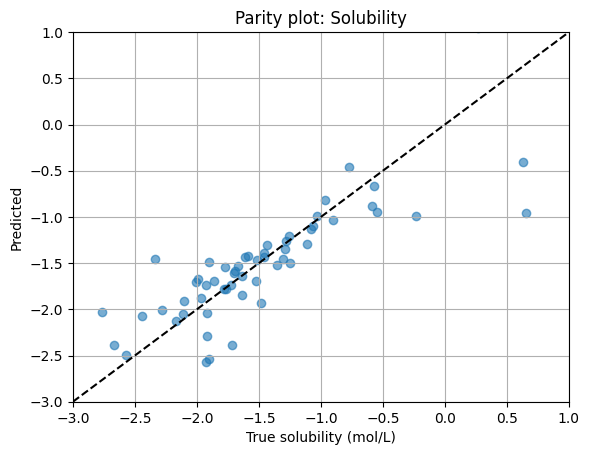

In [167]:
results = trainer.test(mpnn_sol, test_loader)

# Gather predictions for parity
import torch
with torch.inference_mode():
    preds = trainer.predict(mpnn_sol, test_loader)
preds = np.concatenate(preds, axis=0).ravel()

y_true = test_set.Y.ravel()
print("Test size:", len(y_true))

plt.scatter(y_true, preds, alpha=0.6)

# Set both axes to the same range
lims = [-3, 1]
plt.plot(lims, lims, "k--")
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("True solubility (mol/L)")
plt.ylabel("Predicted")
plt.title("Parity plot: Solubility")
plt.grid(True)
plt.show()

⏰ Exercise

Build a new model call `mpnn_sol_2`.
Change the aggregation from `MeanAggregation()` to `SumAggregation()` and retrain for 10 epochs. Compare RMSE and the parity plot. What changed?

## 4. Property prediction (classification)

Here we predict `toxic` vs `non_toxic`.

### 4.1 Build classification dataset

In [168]:
df_tox = df[["SMILES","tox_bin"]].dropna()
smis = df_tox["SMILES"].tolist()
ys   = df_tox["tox_bin"].astype(int).to_numpy().reshape(-1,1)

tox_dps = [data.MoleculeDatapoint.from_smi(s,y) for s,y in zip(smis,ys)]
mols = [dp.mol for dp in tox_dps]
tr_idx, va_idx, te_idx = data.make_split_indices(mols, "random", (0.8,0.1,0.1))
tr, va, te = data.split_data_by_indices(tox_dps, tr_idx, va_idx, te_idx)

feat = featurizers.SimpleMoleculeMolGraphFeaturizer()
tox_tr = data.MoleculeDataset(tr[0], featurizer=feat)
tox_va = data.MoleculeDataset(va[0], featurizer=feat)
tox_te = data.MoleculeDataset(te[0], featurizer=feat)

### 4.2 Model and training

In [169]:
mp  = nn.BondMessagePassing()
agg = nn.MeanAggregation()
ffn = nn.BinaryClassificationFFN(n_tasks=1)
mpnn_tox = models.MPNN(mp, agg, ffn, batch_norm=False)

tr_loader = data.build_dataloader(tox_tr, num_workers=0)
va_loader = data.build_dataloader(tox_va, num_workers=0, shuffle=False)
te_loader = data.build_dataloader(tox_te, num_workers=0, shuffle=False)

trainer_tox = pl.Trainer(logger=False, enable_checkpointing=True, accelerator="auto",
                         devices=1, max_epochs=15)
trainer_tox.fit(mpnn_tox, tr_loader, va_loader)
trainer_tox.test(mpnn_tox, te_loader)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO: 
  | Name            | Type                    | Params | Mode 
--------------------------------------------------------------------
0 | message_passing | BondMessagePassing      | 227 K  | train
1 | agg             | MeanAggregation         | 0      | train
2 | bn              | Identity                | 0      | train
3 | predictor       | BinaryClassificationFFN | 90.6 K | train
4 | X_d_tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/roc          │    0.8639456033706665     │
└───────────────────────────┴───────────────────────────┘

[{'test/roc': 0.8639456033706665}]

### 4.3 ROC curve

Predicting: |          | 0/? [00:00<?, ?it/s]

Test AUC: 0.864  Accuracy: 0.862


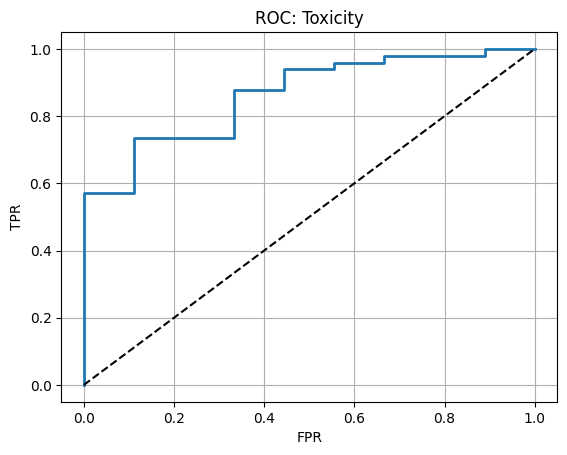

In [170]:
# Gather probabilities
with torch.inference_mode():
    pred_chunks = trainer_tox.predict(mpnn_tox, te_loader)
proba = np.concatenate(pred_chunks, axis=0).ravel()
y_true = tox_te.Y.ravel().astype(int)

auc = roc_auc_score(y_true, proba)
acc = accuracy_score(y_true, (proba>=0.5).astype(int))
print(f"Test AUC: {auc:.3f}  Accuracy: {acc:.3f}")

fpr, tpr, thr = roc_curve(y_true, proba)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC: Toxicity")
plt.grid(True)
plt.show()

## 5. Reactivity and selectivity

Two targets in this dataset relate to reactions.

- **Reactivity**: binary at the molecule level.
- **Selectivity**: oxidation site indices at the atom level.


Before we train models, let’s **look at the labels**. Let's pick three representative molecules from the C-H oxidation dataset and see their reactivity and selectivity label.


In [171]:
# Helper selection: one negative (no reaction), one positive with a single site, one positive with multiple sites
def pick_representatives(df):
    df_pos = df[(df["react_bin"] == 1) & (df["site_list"].map(len) >= 1)].copy()
    df_pos_multi = df_pos[df_pos["site_list"].map(len) >= 2].copy()
    df_neg = df[(df["react_bin"] == 0)].copy()

    reps = []
    if not df_neg.empty:
        reps.append(("Negative (react_bin=0)", df_neg.iloc[0]))
    if not df_pos.empty:
        reps.append(("Positive (react_bin=1; 1 site)", df_pos[df_pos["site_list"].map(len) == 1].iloc[0]
                     if (df_pos["site_list"].map(len) == 1).any() else df_pos.iloc[0]))
    if not df_pos_multi.empty:
        reps.append(("Positive (react_bin=1; multi-site)", df_pos_multi.iloc[0]))

    # If fewer than 3 examples exist, just return what we have
    return reps

reps = pick_representatives(df)
len(reps), [t for t,_ in reps]
# Show the chosen rows so readers see SMILES and labels
import pandas as pd

def row_view(r):
    return {
        "SMILES": r["SMILES"],
        "react_bin": r["react_bin"],
        "site_list (1-based)": r["site_list"]
    }

rep_table = pd.DataFrame([row_view(row) for _, row in reps])
rep_table

SMILES  react_bin site_list (1-based)
0  Nc1c(Oc2ccccc2)cc(O)c2c1C(=O)c1ccccc1C2=O          0                [-1]
1                     c1ccc2c(c1)Cc1ccccc1-2          1                 [7]
2                           c1ccc2c(c1)CCOC2          1             [8, 10]

Let's draw them:

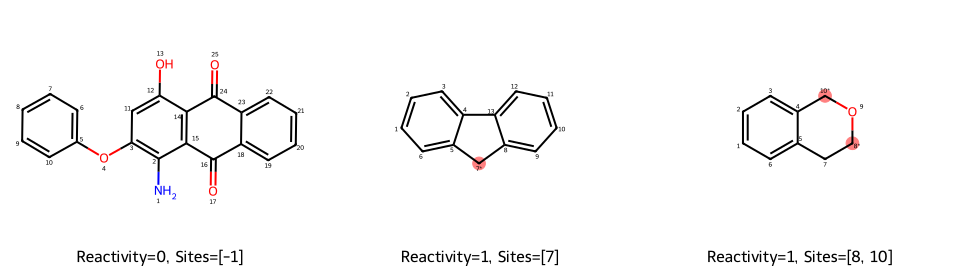

In [172]:
from rdkit.Chem.Draw import rdMolDraw2D

def make_annotated_copy(mol, site_list_1based=None, tag_c123=True):
    m = Chem.Mol(mol)  # copy
    Chem.AssignAtomChiralTagsFromStructure(m)
    Chem.Kekulize(m, clearAromaticFlags=True)
    n = m.GetNumAtoms()
    # Highlight oxidation sites (convert to 0-based safely)
    hi_atoms = []
    if site_list_1based:
        for idx1 in site_list_1based:
            j = idx1 - 1
            if 0 <= j < n:
                hi_atoms.append(j)

    # Always annotate the atom index so readers see 1-based indexing used in labels
    for j in range(n):
        a = m.GetAtomWithIdx(j)
        idx1 = j + 1
        old = a.GetProp("atomNote") if a.HasProp("atomNote") else ""
        # If this atom is an oxidation site, add a star
        star = "*" if (j in hi_atoms) else ""
        a.SetProp("atomNote", f"{old} {idx1}{star}".strip())

    return m, hi_atoms

def draw_examples(reps, mol_size=(320, 280)):
    ms = []
    legends = []
    highlights = []

    for title, row in reps:
        smi = row["SMILES"]
        m = Chem.MolFromSmiles(smi)
        if m is None:
            continue
        m_annot, hi = make_annotated_copy(m, site_list_1based=row["site_list"], tag_c123=True)
        ms.append(m_annot)
        lbl = f"Reactivity={row['react_bin']}, Sites={row['site_list']}"
        legends.append(lbl)
        highlights.append(hi)

    imgs = []
    for m, hi, lg in zip(ms, highlights, legends):
        img = Draw.MolToImage(m, size=mol_size, highlightAtoms=hi)
        img.info["legend"] = lg
        imgs.append(img)

    # Create a grid image manually by re-drawing with legends
    return Draw.MolsToGridImage(ms, molsPerRow=len(ms), subImgSize=mol_size,
                                legends=legends,
                                highlightAtomLists=highlights)

grid_img = draw_examples(reps)
grid_img


### 5.1 Reactivity classifier

This mirrors the toxicity classification workflow we saw before.

In [173]:
df_rxn = df[["SMILES","react_bin"]].dropna()
smis = df_rxn["SMILES"].tolist()
ys   = df_rxn["react_bin"].astype(int).to_numpy().reshape(-1,1)

rxn_dps = [data.MoleculeDatapoint.from_smi(s,y) for s,y in zip(smis, ys)]
mols = [dp.mol for dp in rxn_dps]
tr_idx, va_idx, te_idx = data.make_split_indices(mols, "random", (0.8,0.1,0.1))
tr, va, te = data.split_data_by_indices(rxn_dps, tr_idx, va_idx, te_idx)

feat = featurizers.SimpleMoleculeMolGraphFeaturizer()
rxn_tr = data.MoleculeDataset(tr[0], featurizer=feat)
rxn_va = data.MoleculeDataset(va[0], featurizer=feat)
rxn_te = data.MoleculeDataset(te[0], featurizer=feat)

mp  = nn.BondMessagePassing()
agg = nn.MeanAggregation()
ffn = nn.BinaryClassificationFFN(n_tasks=1)
mpnn_rxn = models.MPNN(mp, agg, ffn, batch_norm=False)

tr_loader = data.build_dataloader(rxn_tr, num_workers=0)
va_loader = data.build_dataloader(rxn_va, num_workers=0, shuffle=False)
te_loader = data.build_dataloader(rxn_te, num_workers=0, shuffle=False)

trainer_rxn = pl.Trainer(logger=False, enable_checkpointing=True, accelerator="auto",
                         devices=1, max_epochs=15)
trainer_rxn.fit(mpnn_rxn, tr_loader, va_loader)
trainer_rxn.test(mpnn_rxn, te_loader)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO: 
  | Name            | Type                    | Params | Mode 
--------------------------------------------------------------------
0 | message_passing | BondMessagePassing      | 227 K  | train
1 | agg             | MeanAggregation         | 0      | train
2 | bn              | Identity                | 0      | train
3 | predictor       | BinaryClassificationFFN | 90.6 K | train
4 | X_d_tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/roc          │     0.958184003829956     │
└───────────────────────────┴───────────────────────────┘

[{'test/roc': 0.958184003829956}]

In [174]:
import ast

def atoms_labels_from_smiles(smi, positive_idxs):
    if Chem is None:
        return None
    m = Chem.MolFromSmiles(smi)
    if m is None:
        return None
    n = m.GetNumAtoms()
    y = np.zeros((n,1), dtype=float)
    for idx in positive_idxs:
        # dataset uses 1-based indexing in the text, RDKit uses 0-based
        j = idx-1
        if 0 <= j < n:
            y[j,0] = 1.0
    return y

# Build list of MolAtomBondDatapoint for selectivity
sel_rows = df[["SMILES","site_list"]].dropna()
sel_dps = []
for smi, sites in sel_rows.itertuples(index=False):
    atom_y = atoms_labels_from_smiles(smi, sites)
    if atom_y is None:
        continue
    # We provide atom_y, molecule-level y is optional here
    dp = data.MolAtomBondDatapoint.from_smi(
        smi, atom_y=atom_y, reorder_atoms=False
    )
    sel_dps.append(dp)

len(sel_dps), type(sel_dps[0]).__name__

(575, 'MolAtomBondDatapoint')

In [175]:
mols = [Chem.MolFromSmiles(dp.name) if hasattr(dp, "name") else None for dp in sel_dps]
# For structure-based split we need RDKit Mol. Build directly from SMILES fallback:
mols = [Chem.MolFromSmiles(df.loc[df["SMILES"]==dp.name, "SMILES"].iloc[0]) if Chem else None for dp in sel_dps]

tr_idx, va_idx, te_idx = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))
tr, va, te = data.split_data_by_indices(sel_dps, tr_idx, va_idx, te_idx)

feat = featurizers.SimpleMoleculeMolGraphFeaturizer()
tr_set = data.MolAtomBondDataset(tr[0], featurizer=feat)
va_set = data.MolAtomBondDataset(va[0], featurizer=feat)
te_set = data.MolAtomBondDataset(te[0], featurizer=feat)

tr_loader = data.build_dataloader(tr_set, shuffle=True, batch_size=8)
va_loader = data.build_dataloader(va_set, shuffle=False, batch_size=8)
te_loader = data.build_dataloader(te_set, shuffle=False, batch_size=8)

In [176]:
mp = nn.MABBondMessagePassing(
    d_v=feat.atom_fdim, d_e=feat.bond_fdim, d_h=300, depth=3, dropout=0.1
)
agg = nn.MeanAggregation()

atom_predictor = nn.BinaryClassificationFFN(n_tasks=1)  # atom-level 0/1

model_sel = models.MolAtomBondMPNN(
    message_passing=mp,
    agg=agg,
    mol_predictor=None,
    atom_predictor=atom_predictor,
    bond_predictor=None,
    batch_norm=True,
    metrics=[nn.metrics.BinaryAUROC()],
)

trainer_sel = pl.Trainer(logger=False, enable_checkpointing=True, accelerator="auto",
                         devices=1, max_epochs= EPOCHS) #You can change this number at the begining of this notebook
trainer_sel.fit(model_sel, tr_loader, va_loader)
trainer_sel.test(model_sel, te_loader)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO: 
  | Name            | Type                    | Params | Mode 
--------------------------------------------------------------------
0 | message_passing | MABBondMessagePassing   | 322 K  | train
1 | agg             | MeanAggregation         | 0      | train
2 | atom_predictor  | BinaryClassificationFFN | 90.6 K | train
3 | bns             | ModuleList              | 600    | train
4 | X_d_tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       atom_test/roc       │    0.8670018315315247     │
└───────────────────────────┴───────────────────────────┘

[{'atom_test/roc': 0.8670018315315247}]

Atom count: 10
First 10 probabilities: [0.5        0.5000001  0.5        0.5        0.5000006  0.5000006
 0.503788   0.5000002  0.7055641  0.50000006]


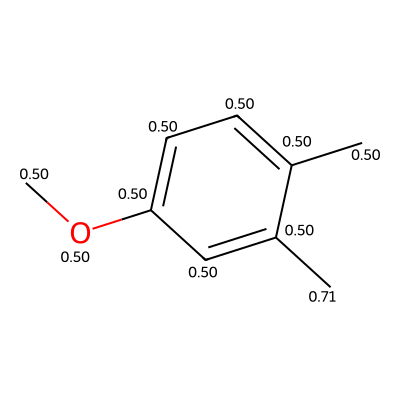

In [177]:
# 1) Pick which test item to visualize
idx = 11  # change as you like

# 2) Grab the original datapoint (not the already-featurized datum)
dp = te_set.data[idx]   # IMPORTANT: .data gives you the raw MolAtomBondDatapoint

# 3) Make a one-item MolAtomBondDataset with the SAME featurizer you used before
single_ds = data.MolAtomBondDataset([dp], featurizer=feat)

# 4) Build a loader and get its batch
single_loader = data.build_dataloader(single_ds, shuffle=False, batch_size=1)
batch = next(iter(single_loader))  # this now matches collate expectations

with torch.inference_mode():
    out = model_sel(batch[0], None)   # batch[0] is the MolGraphBatch

# 6) Unpack outputs and get per-atom probabilities
_, atom_logits, _ = out
atom_probs = torch.sigmoid(atom_logits).cpu().numpy().ravel()

print("Atom count:", len(atom_probs))
print("First 10 probabilities:", atom_probs[:10])

# 7) Draw the SAME molecule with aligned probabilities
smi = dp.name  # MolAtomBondDatapoint stores SMILES in .name
m = Chem.MolFromSmiles(smi)
m2 = Chem.Mol(m)
for i, a in enumerate(m2.GetAtoms()):
    a.SetProp("atomNote", f"{atom_probs[i]:.2f}")
img = Draw.MolToImage(m2, size=(400, 400))
display(img)


⏰ **Exercise**

Change `idx` above to take a look at other molecules in test set.

## 6. Rationale

In this section we ask **why** the model makes its predictions. Instead of just reporting a number for solubility or reactivity, we try to find the *substructures* of a molecule that drive the prediction.

The method we use is a simplified form of **Monte Carlo Tree Search (MCTS) rationale extraction** from the Chemprop:

1. **Start with the whole molecule** and its predicted property.
2. **Systematically remove small fragments** (like a bond or a ring) and check how the model’s prediction changes for the remaining subgraph.
3. Build a search tree of candidate subgraphs and keep the ones that still predict strongly for the property of interest.
4. From this set, report the **smallest and most predictive subgraph** as the *rationale*.


In [178]:
# ===== Shared helpers for both tasks (Chemprop v2.2.1) =====
from dataclasses import dataclass, field
from typing import Callable, Iterable, List, Tuple, Union
import math, time
import numpy as np
import pandas as pd
import torch
from lightning import pytorch as pl
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import display, Image

from chemprop import data, models
from chemprop.models import MPNN

# Predict a list of SMILES with a single-task model. Returns array shape (n, 1).
def make_prediction(models_in: List[MPNN], trainer_in: pl.Trainer, smiles: List[str]) -> np.ndarray:
    test_data = [data.MoleculeDatapoint.from_smi(s) for s in smiles]
    test_dset = data.MoleculeDataset(test_data)
    test_loader = data.build_dataloader(test_dset, batch_size=1, num_workers=0, shuffle=False)
    with torch.inference_mode():
        agg = None
        for m in models_in:
            pred_batches = trainer_in.predict(m, test_loader)  # list of tensors/arrays
            preds = torch.cat([torch.as_tensor(pb) for pb in pred_batches], dim=0).cpu().numpy()
            agg = preds if agg is None else (agg + preds)
    return agg / len(models_in)

# ---- MCTS components (as in tutorial, with safer kekulize handling) ----
@dataclass
class MCTSNode:
    smiles: str
    atoms: Iterable[int]
    W: float = 0
    N: float = 0
    P: float = 0
    children: list = field(default_factory=list)
    def __post_init__(self): self.atoms = set(self.atoms)
    def Q(self) -> float: return self.W / self.N if self.N > 0 else 0
    def U(self, n: int, c_puct: float = 10.0) -> float: return c_puct * self.P * math.sqrt(n) / (1 + self.N)

def find_clusters(mol: Chem.Mol) -> Tuple[List[Tuple[int,...]], List[List[int]]]:
    n = mol.GetNumAtoms()
    if n == 1: return [(0,)], [[0]]
    clusters = []
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        if not b.IsInRing():
            clusters.append((i, j))
    ssr = [tuple(x) for x in Chem.GetSymmSSSR(mol)]
    clusters.extend(ssr)
    atom_cls = [[] for _ in range(n)]
    for k, cl in enumerate(clusters):
        for a in cl: atom_cls[a].append(k)
    return clusters, atom_cls

def extract_subgraph_from_mol(mol: Chem.Mol, selected_atoms: set) -> Tuple[Chem.Mol, List[int]]:
    sel = set(selected_atoms)
    roots = []
    for idx in sel:
        atom = mol.GetAtomWithIdx(idx)
        if any(nei.GetIdx() not in sel for nei in atom.GetNeighbors()):
            roots.append(idx)
    rw = Chem.RWMol(mol)
    for idx in roots:
        a = rw.GetAtomWithIdx(idx)
        a.SetAtomMapNum(1)
        aroma = [b for b in a.GetBonds() if b.GetBondType() == Chem.rdchem.BondType.AROMATIC]
        aroma = [b for b in aroma if b.GetBeginAtom().GetIdx() in sel and b.GetEndAtom().GetIdx() in sel]
        if len(aroma) == 0: a.SetIsAromatic(False)
    for idx in sorted([a.GetIdx() for a in rw.GetAtoms() if a.GetIdx() not in sel], reverse=True):
        rw.RemoveAtom(idx)
    return rw.GetMol(), roots

def extract_subgraph(smiles: str, selected_atoms: set) -> Tuple[Union[str,None], Union[List[int],None]]:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return None, None
    # try kekulized
    try:
        mk = Chem.Mol(mol); Chem.Kekulize(mk)
        sub, roots = extract_subgraph_from_mol(mk, selected_atoms)
        try:
            smi = Chem.MolToSmiles(sub, kekuleSmiles=True)
            sub = Chem.MolFromSmiles(smi)
        except Exception: sub = None
        if sub is not None and mol.HasSubstructMatch(sub): return Chem.MolToSmiles(sub), roots
    except Exception:
        pass
    # fallback without kekulize
    sub, roots = extract_subgraph_from_mol(mol, selected_atoms)
    try:
        smi = Chem.MolToSmiles(sub)
        sub = Chem.MolFromSmiles(smi)
    except Exception: sub = None
    return (Chem.MolToSmiles(sub), roots) if sub is not None else (None, None)

def mcts_rollout(node: MCTSNode, state_map, orig_smiles, clusters, atom_cls, nei_cls,
                 scoring_fn: Callable[[List[str]], np.ndarray], min_atoms=8, c_puct=10.0) -> float:
    cur = node.atoms
    if len(cur) <= min_atoms: return node.P
    if len(node.children) == 0:
        cur_cls = set([i for i, x in enumerate(clusters) if x <= cur])
        for i in cur_cls:
            leaf_atoms = [a for a in clusters[i] if len(atom_cls[a] & cur_cls) == 1]
            if len(nei_cls[i] & cur_cls) == 1 or (len(clusters[i]) == 2 and len(leaf_atoms) == 1):
                new_atoms = cur - set(leaf_atoms)
                new_smi, _ = extract_subgraph(orig_smiles, new_atoms)
                if not new_smi: continue
                node.children.append(state_map.get(new_smi, MCTSNode(new_smi, new_atoms)))
        state_map[node.smiles] = node
        if len(node.children) == 0: return node.P
        scores = scoring_fn([x.smiles for x in node.children])
        for child, sc in zip(node.children, scores): child.P = float(sc)
    totalN = sum(c.N for c in node.children)
    nxt = max(node.children, key=lambda x: x.Q() + x.U(totalN, c_puct=c_puct))
    v = mcts_rollout(nxt, state_map, orig_smiles, clusters, atom_cls, nei_cls, scoring_fn, min_atoms=min_atoms, c_puct=c_puct)
    nxt.W += v; nxt.N += 1
    return v

def run_mcts_for_smiles(smi: str, scoring_fn, rollout=10, c_puct=10.0,
                        min_atoms=8, max_atoms=20) -> List[MCTSNode]:
    mol = Chem.MolFromSmiles(smi)
    if mol is None: return []
    clusters_raw, atom_cls_raw = find_clusters(mol)
    clusters = [set(cl) for cl in clusters_raw]
    atom_cls = [set(x) for x in atom_cls_raw]
    nei_cls = []
    for i, cl in enumerate(clusters):
        neigh = [nei for a in cl for nei in atom_cls_raw[a]]
        nei_cls.append(set(neigh) - {i})
    root = MCTSNode(smi, set(range(mol.GetNumAtoms())))
    state_map = {smi: root}
    for _ in range(rollout):
        mcts_rollout(root, state_map, smi, clusters, atom_cls, nei_cls, scoring_fn, min_atoms=min_atoms, c_puct=c_puct)
    rats = [node for _, node in state_map.items() if node.smiles is not None and len(node.atoms) <= max_atoms]
    return rats

# Simple fragment fallback if MCTS cannot find anything
def find_fragments(mol: Chem.Mol):
    frags = []
    for b in mol.GetBonds():
        if not b.IsInRing():
            frags.append({b.GetBeginAtomIdx(), b.GetEndAtomIdx()})
    try:
        for ring in Chem.GetSymmSSSR(mol):
            frags.append(set(int(i) for i in ring))
    except Exception:
        pass
    return frags

def fragment_top1(smi: str, scoring_fn) -> List[Tuple[str, float]]:
    mol = Chem.MolFromSmiles(smi)
    if mol is None: return []
    cands = []
    for aset in find_fragments(mol):
        sub_smi, _ = extract_subgraph(smi, aset)
        if sub_smi: cands.append(sub_smi)
    if not cands: return []
    cands = list(dict.fromkeys(cands))
    scores = scoring_fn(cands)
    idx = int(np.argmax(scores))
    return [(cands[idx], float(scores[idx]))]

def visualize_rationale_on_parent(parent_smi: str, rationale_smi: str, size=(520, 420)):
    pm = Chem.MolFromSmiles(parent_smi)
    rm = Chem.MolFromSmiles(rationale_smi)
    if pm is None or rm is None:
        print("Cannot draw: invalid SMILES.")
        return
    match = pm.GetSubstructMatch(rm)
    hi_atoms = list(match) if match else []
    drawer = rdMolDraw2D.MolDraw2DCairo(size[0], size[1])
    opts = drawer.drawOptions()
    for attr in ("atomLabelFontSize", "fontSize", "scalingFactor"):
        if hasattr(opts, attr):
            try:
                setattr(opts, attr, 0.9)
                break
            except Exception:
                pass
    rdMolDraw2D.PrepareAndDrawMolecule(drawer, pm,
                                       highlightAtoms=hi_atoms if hi_atoms else None)
    drawer.FinishDrawing()
    png = drawer.GetDrawingText()
    display(Image(data=png))



Because scoring is done by predicting each subgraph as if it were a standalone molecule, the absolute values (like negative `logS`) may not be directly comparable to the parent’s score. What matters is the **difference (Δ)**: how much the rationale’s score differs from the parent. A positive Δ means the subgraph supports the property; a negative Δ means removing that part lowers the property.

We generate a **summary table** with one rationale (`rationale_0`) for each molecule:

- `smiles`: the original molecule  
- `logS` or `react_prob`: the model’s prediction on the full molecule  
- `rationale_0`: the SMILES string of the key substructure  
- `rationale_0_score`: the model’s prediction on that substructure  
- `rationale_0_delta`: the difference between rationale and parent  

Finally, we **visualize the rationale** by highlighting the matching atoms in the parent molecule. This lets us

### 6.1 Solubility prediction rationale

In [179]:
# ===== Solubility summary table with top-1 rationale =====
# Uses your trained mpnn_sol and trainer, and df_sol["SMILES"]

models_sol = [mpnn_sol]  # must be single-task regression
prop_name = "logS"

def scoring_fn_sol(smiles_list: List[str]) -> np.ndarray:
    return make_prediction(models_sol, trainer, smiles_list)[:, 0]

# Build table
N = 15  # how many molecules to summarize
sample_smis = df_sol["SMILES"].tolist()[:N]

rows = {"smiles": [], prop_name: [], "rationale_0": [], "rationale_0_score": []}

t0 = time.time()
for smi in sample_smis:
    base = float(scoring_fn_sol([smi])[0])
    rows["smiles"].append(smi)
    rows[prop_name].append(base)

    # size-aware MCTS settings
    mol = Chem.MolFromSmiles(smi)
    n = mol.GetNumAtoms() if mol is not None else 20
    min_atoms = max(3, int(0.30 * n))
    max_atoms = max(min_atoms + 1, int(0.60 * n))

    rats = run_mcts_for_smiles(smi, scoring_fn_sol, rollout=10, c_puct=10.0,
                               min_atoms=min_atoms, max_atoms=max_atoms)

    if rats:
        # choose smallest subgraphs, then highest score
        ms = min(len(x.atoms) for x in rats)
        kept = [x for x in rats if len(x.atoms) == ms and x.smiles is not None]
        kept.sort(key=lambda x: x.P, reverse=True)
        r0 = kept[0].smiles
        r0s = float(kept[0].P)
    else:
        # fallback to fragment top1
        top1 = fragment_top1(smi, scoring_fn_sol)
        if top1:
            r0, r0s = top1[0]
        else:
            r0, r0s = None, None

    rows["rationale_0"].append(r0)
    rows["rationale_0_score"].append(r0s)

elapsed = time.time() - t0
print(f"Solubility: built table for {len(sample_smis)} molecules in {elapsed:.2f}s")



solubility_rationales = pd.DataFrame(rows)
solubility_rationales



Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Solubility: built table for 15 molecules in 3.48s


smiles      logS              rationale_0  \
0         c1ccc2c(c1)CCOC2 -1.195756      C1C[CH:1]=[CH:1]CO1   
1   c1ccc2c(c1)Cc1ccccc1-2 -1.719822       c1cc[cH:1][cH:1]c1   
2         c1ccc2c(c1)CCCC2 -1.534268      C1CC[CH:1]=[CH:1]C1   
3               CCc1ccccc1 -1.301932                 C[CH3:1]   
4                C1=CCCCC1 -1.092782                C1=CCCCC1   
5                  C1CCSC1 -0.878732                  C1CCSC1   
6               CN1CCCC1=O -0.318836                O=[CH2:1]   
7              COCc1ccccc1 -1.092736               COC[CH3:1]   
8        CCCCN1Cc2ccccc2C1 -1.399117  C1[CH:1]=[CH:1]C[NH:1]1   
9              CCCc1ccccc1 -1.500662                 C[CH3:1]   
10  CCCCCCCCOCc1ccc(OC)cc1 -2.007931       c1c[cH:1]cc[cH:1]1   
11       CC(C)CCOCc1ccccc1 -1.739935       C(O[CH3:1])[CH3:1]   
12              CC1=CCCCC1 -1.427984                 C[CH3:1]   
13           CC1=C(C)CCCC1 -1.500649                 C[CH3:1]   
14                C1=CCCC1 -1.037244                 C1=CCCC1   

    rationale_0_score  
0           -0.505139  
1           -0.771889  
2           -1.092782  
3           -0.297537  
4           -1.092782  
5           -0.878732  
6            1.264910  
7           -0.250766  
8            0.487650  
9           -0.297537  
10          -0.771889  
11          -0.250766  
12          -0.297537  
13          -0.297537  
14          -1.037244

Parent: c1ccc2c(c1)CCOC2
Rationale 0: C1C[CH:1]=[CH:1]CO1  score= -0.5051385164260864


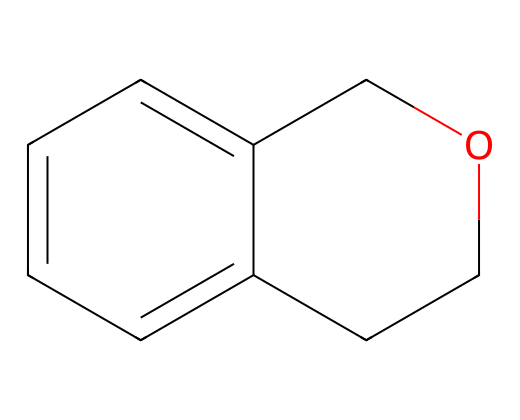

In [180]:
if pd.notna(solubility_rationales.loc[0, "rationale_0"]):
    parent = solubility_rationales.loc[0, "smiles"]
    rat    = solubility_rationales.loc[0, "rationale_0"]
    print("Parent:", parent)
    print("Rationale 0:", rat, " score=", solubility_rationales.loc[0, "rationale_0_score"])
    visualize_rationale_on_parent(parent, rat)


### 6.2 Reactivity prediction rationale

In [181]:
# ===== Reactivity summary table with top-1 rationale =====
# Uses your trained mpnn_rxn and trainer_rxn, and df_rxn["SMILES"]

models_rxn = [mpnn_rxn]     # single-task binary classification head
trainer_cls = trainer_rxn   # your classification trainer

def scoring_fn_rxn(smiles_list: List[str]) -> np.ndarray:
    # predict logits, convert to probabilities with sigmoid
    preds = make_prediction(models_rxn, trainer_cls, smiles_list)[:, 0]
    # Some builds return probs already; to be safe, apply sigmoid if outside [0,1]
    if ((preds < 0) | (preds > 1)).any():
        preds = 1.0 / (1.0 + np.exp(-preds))
    return preds.reshape(-1,)

# Build table
N = 15
sample_smis_rxn = df_rxn["SMILES"].tolist()[:N]

rows_rxn = {"smiles": [], "react_prob": [], "rationale_0": [], "rationale_0_score": []}

t0 = time.time()
for smi in sample_smis_rxn:
    base_p = float(scoring_fn_rxn([smi])[0])
    rows_rxn["smiles"].append(smi)
    rows_rxn["react_prob"].append(base_p)

    mol = Chem.MolFromSmiles(smi)
    n = mol.GetNumAtoms() if mol is not None else 20
    min_atoms = max(3, int(0.30 * n))
    max_atoms = max(min_atoms + 1, int(0.60 * n))

    rats = run_mcts_for_smiles(smi, scoring_fn_rxn, rollout=10, c_puct=10.0,
                               min_atoms=min_atoms, max_atoms=max_atoms)

    if rats:
        ms = min(len(x.atoms) for x in rats)
        kept = [x for x in rats if len(x.atoms) == ms and x.smiles is not None]
        kept.sort(key=lambda x: x.P, reverse=True)
        r0 = kept[0].smiles
        r0s = float(kept[0].P)
    else:
        top1 = fragment_top1(smi, scoring_fn_rxn)
        if top1:
            r0, r0s = top1[0]
        else:
            r0, r0s = None, None

    rows_rxn["rationale_0"].append(r0)
    rows_rxn["rationale_0_score"].append(r0s)

elapsed = time.time() - t0
print(f"Reactivity: built table for {len(sample_smis_rxn)} molecules in {elapsed:.2f}s")

reactivity_rationales = pd.DataFrame(rows_rxn)
reactivity_rationales


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Reactivity: built table for 15 molecules in 6.96s


smiles  react_prob                    rationale_0  \
0         c1ccc2c(c1)CCOC2    0.944441            C1C[CH:1]=[CH:1]CO1   
1   c1ccc2c(c1)Cc1ccccc1-2    0.867228  C1[CH:1]=[CH:1][CH:1]=[CH:1]1   
2         c1ccc2c(c1)CCCC2    0.966502            C1CC[CH:1]=[CH:1]C1   
3               CCc1ccccc1    0.908582                  c1cc[cH:1]cc1   
4                C1=CCCCC1    0.960123                      C1=CCCCC1   
5                  C1CCSC1    0.963128                        C1CCSC1   
6               CN1CCCC1=O    0.877834             C1C[CH2:1][NH:1]C1   
7              COCc1ccccc1    0.876020                     COC[CH3:1]   
8        CCCCN1Cc2ccccc2C1    0.945808                     CCC[CH3:1]   
9              CCCc1ccccc1    0.923266                     CCC[CH3:1]   
10  CCCCCCCCOCc1ccc(OC)cc1    0.920641           C(CC[CH3:1])C[CH3:1]   
11       CC(C)CCOCc1ccccc1    0.906913               C[CH2:1]C[CH3:1]   
12              CC1=CCCCC1    0.958145                 C1=[CH:1]CCCC1   
13           CC1=C(C)CCCC1    0.955647            C1CC[CH:1]=[CH:1]C1   
14                C1=CCCC1    0.952870                       C1=CCCC1   

    rationale_0_score  
0            0.916721  
1            0.841032  
2            0.960123  
3            0.825776  
4            0.960123  
5            0.963128  
6            0.958719  
7            0.841456  
8            0.916729  
9            0.916729  
10           0.949148  
11           0.916729  
12           0.960123  
13           0.960123  
14           0.952870

Parent: c1ccc2c(c1)CCOC2
Rationale 0: C1C[CH:1]=[CH:1]CO1  score= 0.9167211055755615


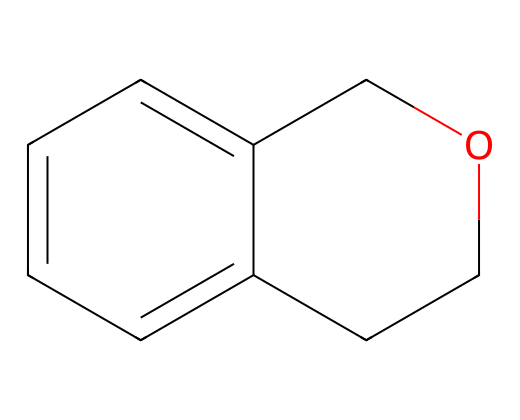

In [182]:
if pd.notna(reactivity_rationales.loc[0, "rationale_0"]):
    parent = reactivity_rationales.loc[0, "smiles"]
    rat    = reactivity_rationales.loc[0, "rationale_0"]
    print("Parent:", parent)
    print("Rationale 0:", rat, " score=", reactivity_rationales.loc[0, "rationale_0_score"])
    visualize_rationale_on_parent(parent, rat)


## 7. Chemprop CLI (Command-Line Interface)





Prepare a minimal CSV: `SMILES,Melting Point`.

In [199]:
# Load data and write a small CSV
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df = pd.read_csv(url)
reg_cols = ["SMILES", "Melting Point"]
df_reg = df[reg_cols].dropna().copy()
df_reg.head(3)

SMILES  Melting Point
0        c1ccc2c(c1)CCOC2           65.8
1  c1ccc2c(c1)Cc1ccccc1-2           90.0
2        c1ccc2c(c1)CCCC2           69.4

Save to disk for Chemprop CLI.

In [200]:
df_reg.to_csv("mp_data.csv", index=False)
len(df_reg), df_reg.head(2)

(575,
                    SMILES  Melting Point
 0        c1ccc2c(c1)CCOC2           65.8
 1  c1ccc2c(c1)Cc1ccccc1-2           90.0)

Train a **small** model so it runs in class. We log common metrics.

In [204]:
# A short run. Increase epochs later if you have time/GPU.
!chemprop train \
  --data-path mp_data.csv \
  -t regression \
  -s SMILES \
  --target-columns "Melting Point" \
  -o mp_model \
  --num-replicates 1 \
  --epochs 100 \
  --save-smiles-splits \
  --metrics mae rmse r2 \
  --tracking-metric r2

2025-09-21T02:36:17 - INFO:chemprop.cli.main - Running in mode 'train' with args: {'smiles_columns': ['SMILES'], 'reaction_columns': None, 'no_header_row': False, 'num_workers': 0, 'batch_size': 64, 'accelerator': 'auto', 'devices': 'auto', 'rxn_mode': 'REAC_DIFF', 'multi_hot_atom_featurizer_mode': 'V2', 'keep_h': False, 'add_h': False, 'ignore_stereo': False, 'reorder_atoms': False, 'molecule_featurizers': None, 'descriptors_path': None, 'descriptors_columns': None, 'no_descriptor_scaling': False, 'no_atom_feature_scaling': False, 'no_atom_descriptor_scaling': False, 'no_bond_feature_scaling': False, 'no_bond_descriptor_scaling': False, 'atom_features_path': None, 'atom_descriptors_path': None, 'bond_features_path': None, 'bond_descriptors_path': None, 'constraints_path': None, 'constraints_to_targets': None, 'use_cuikmolmaker_featurization': False, 'config_path': None, 'data_path': PosixPath('mp_data.csv'), 'output_dir': PosixPath('mp_model'), 'remove_checkpoints': False, 'checkpoint

Make quick predictions on a few molecules.

In [205]:
smiles_list = [
    "CO",
    "c1ccc2c(c1)CCCC2",
    "CCCCCCCCC(=O)O",
    "CCN(CC)CC"
]
pd.DataFrame({"SMILES": smiles_list}).to_csv("custom_smiles_reg.csv", index=False)

!chemprop predict \
  --test-path custom_smiles_reg.csv \
    --model-paths mp_model/model_0/best.pt \
  --preds-path mp_preds.csv

pd.read_csv("mp_preds.csv")


2025-09-21T02:38:41 - INFO:chemprop.cli.main - Running in mode 'predict' with args: {'smiles_columns': None, 'reaction_columns': None, 'no_header_row': False, 'num_workers': 0, 'batch_size': 64, 'accelerator': 'auto', 'devices': 'auto', 'rxn_mode': 'REAC_DIFF', 'multi_hot_atom_featurizer_mode': 'V2', 'keep_h': False, 'add_h': False, 'ignore_stereo': False, 'reorder_atoms': False, 'molecule_featurizers': None, 'descriptors_path': None, 'descriptors_columns': None, 'no_descriptor_scaling': False, 'no_atom_feature_scaling': False, 'no_atom_descriptor_scaling': False, 'no_bond_feature_scaling': False, 'no_bond_descriptor_scaling': False, 'atom_features_path': None, 'atom_descriptors_path': None, 'bond_features_path': None, 'bond_descriptors_path': None, 'constraints_path': None, 'constraints_to_targets': None, 'use_cuikmolmaker_featurization': False, 'test_path': PosixPath('custom_smiles_reg.csv'), 'output': PosixPath('mp_preds.csv'), 'drop_extra_columns': False, 'model_paths': [PosixPath(

SMILES  Melting Point
0                CO      76.238464
1  c1ccc2c(c1)CCCC2      76.600280
2    CCCCCCCCC(=O)O      91.757965
3         CCN(CC)CC      80.074980

### 7.3 Reactivity classification (C–H oxidation dataset)

We use the `Reactivity` column and convert it to **binary** 0/1.

In [192]:
df = pd.read_csv(url)
df["Reactivity_bin"] = df["Reactivity"].replace({-1: 0}).astype(int)
df[["SMILES","Reactivity","Reactivity_bin"]].head(3)

SMILES  Reactivity  Reactivity_bin
0        c1ccc2c(c1)CCOC2           1               1
1  c1ccc2c(c1)Cc1ccccc1-2           1               1
2        c1ccc2c(c1)CCCC2           1               1

Write a minimal file.

In [193]:
df[["SMILES", "Reactivity_bin"]].to_csv("reactivity_data_bin.csv", index=False)

# Optional: sanity check the class balance
print(df["Reactivity"].value_counts(dropna=False).to_dict())
print(df["Reactivity_bin"].value_counts(dropna=False).to_dict())

{-1: 311, 1: 264}
{0: 311, 1: 264}


Train a short classification model.

In [194]:
!chemprop train \
  --data-path reactivity_data_bin.csv \
  -t classification \
  -s SMILES \
  --target-columns Reactivity_bin \
  -o reactivity_model \
  --num-replicates 1 \
  --epochs 15 \
  --class-balance \
  --metrics roc prc accuracy \
  --tracking-metric roc

2025-09-21T02:30:14 - INFO:chemprop.cli.main - Running in mode 'train' with args: {'smiles_columns': ['SMILES'], 'reaction_columns': None, 'no_header_row': False, 'num_workers': 0, 'batch_size': 64, 'accelerator': 'auto', 'devices': 'auto', 'rxn_mode': 'REAC_DIFF', 'multi_hot_atom_featurizer_mode': 'V2', 'keep_h': False, 'add_h': False, 'ignore_stereo': False, 'reorder_atoms': False, 'molecule_featurizers': None, 'descriptors_path': None, 'descriptors_columns': None, 'no_descriptor_scaling': False, 'no_atom_feature_scaling': False, 'no_atom_descriptor_scaling': False, 'no_bond_feature_scaling': False, 'no_bond_descriptor_scaling': False, 'atom_features_path': None, 'atom_descriptors_path': None, 'bond_features_path': None, 'bond_descriptors_path': None, 'constraints_path': None, 'constraints_to_targets': None, 'use_cuikmolmaker_featurization': False, 'config_path': None, 'data_path': PosixPath('reactivity_data_bin.csv'), 'output_dir': PosixPath('reactivity_model'), 'remove_checkpoints'

Predict on new SMILES.

In [196]:
smiles_list = [
    "CCO",
    "c1ccccc1C(F)",
    "C1=C([C@@H]2C[C@H](C1)C2(C)C)",
    "C1=CC=CC=C1C=O",
    "CCN(CC)CC",
    "c1cccc(C=CC)c1"
]
pd.DataFrame({"SMILES": smiles_list}).to_csv("custom_smiles.csv", index=False)

!chemprop predict \
  --test-path custom_smiles.csv \
  --model-paths reactivity_model/model_0/best.pt \
  --preds-path custom_preds.csv

pd.read_csv("custom_preds.csv")

2025-09-21T02:32:16 - INFO:chemprop.cli.main - Running in mode 'predict' with args: {'smiles_columns': None, 'reaction_columns': None, 'no_header_row': False, 'num_workers': 0, 'batch_size': 64, 'accelerator': 'auto', 'devices': 'auto', 'rxn_mode': 'REAC_DIFF', 'multi_hot_atom_featurizer_mode': 'V2', 'keep_h': False, 'add_h': False, 'ignore_stereo': False, 'reorder_atoms': False, 'molecule_featurizers': None, 'descriptors_path': None, 'descriptors_columns': None, 'no_descriptor_scaling': False, 'no_atom_feature_scaling': False, 'no_atom_descriptor_scaling': False, 'no_bond_feature_scaling': False, 'no_bond_descriptor_scaling': False, 'atom_features_path': None, 'atom_descriptors_path': None, 'bond_features_path': None, 'bond_descriptors_path': None, 'constraints_path': None, 'constraints_to_targets': None, 'use_cuikmolmaker_featurization': False, 'test_path': PosixPath('custom_smiles.csv'), 'output': PosixPath('custom_preds.csv'), 'drop_extra_columns': False, 'model_paths': [PosixPath(

SMILES  Reactivity_bin
0                            CCO        0.588819
1                   c1ccccc1C(F)        0.690307
2  C1=C([C@@H]2C[C@H](C1)C2(C)C)        0.899083
3                 C1=CC=CC=C1C=O        0.461047
4                      CCN(CC)CC        0.745579
5                 c1cccc(C=CC)c1        0.628841

## 7. Quick Reference

- An MLP ignores graph structure. A GNN uses edges to mix neighbor information.  
- The core update is neighbor aggregation followed by a learnable transformation.  
- Chemprop encodes many best practices so you can focus on data and targets.  



## 8. Glossary

graph neural network
  >A neural model that updates node states by aggregating messages from neighbors.

message passing
  >The update step where a node combines its own vector with aggregated neighbor vectors.

readout (pooling)
  >Operation that compresses node states into a single graph vector, often by sum, mean, or max.

edge index
  >A 2×E tensor listing source and destination of each edge.

Chemprop
  >A practical library that trains message passing networks directly from SMILES.

replicate
  >Independent training run with a different random seed. Often ensembled for stability.

tracking metric
  >The metric used to pick the best checkpoint during training.

class balance
  >Loss weighting that compensates for skewed class proportions.

## 10. In‑class activity


---

### Q1. Chemprop regression on melting point

- Train Chemprop on `mp_data.csv` for `--epochs 20`  
- Predict on at least 5 new SMILES of your choice and list the predictions

In [ ]:
# TO DO

---

### Q2. Chemprop classification on toxicity (student challenge)

- Convert `Toxicity` to `1/0` using the mapping `{toxic:1, non_toxic:0}`  
- Save `["SMILES","Toxicity_bin"]` to `tox_data.csv`  
- Train with `--class-balance --epochs 20` and metrics `roc prc accuracy`  
- Predict on a small set of SMILES;
- Optional: show the class probability

In [ ]:
# TO DO